# Figure 3 完整复现工作流

**目标**：基于一个统一的脚本，生成复现 Figure 3 所需的三个子图 (a, b, c) 的全部数据，并绘制最终的复合图表。

1.  **子图 (a)**: CHSH 不等式，对比 SGA 和 CSPSA。
2.  **子图 (b)**: Instrumental 不等式，对比 SGA 和标准 CSPSA (离散扰动)。
3.  **子图 (c)**: Instrumental 不等式，对比 SGA 和修改版 CSPSA (连续扰动)。

In [418]:
# --- 1. 导入与设置 ---
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import multiprocessing
from functools import partial
import time

# 导入所有需要的模拟函数
# 确保您的环境中已有名为 cspsa_poisson.py 和 sga_poisson.py 的文件
from sga_poisson import run_sga_chsh_simulation, run_sga_simulation
from cspsa_poisson import run_cspsa_chsh_simulation, run_cspsa_simulation

from simulation_utils_poisson import calculate_cspsa_violation
from simulation_utils_poisson import calculate_cspsa_chsh_violation

In [419]:
# --- 2. 辅助函数：量子态生成 ---
def generate_werner_state(purity):
    """为CHSH生成2-qubit Werner态。purity=1时为最大纠缠态。"""
    psi_max_entangled = (qt.tensor(qt.basis(2, 0), qt.basis(2, 0)) + qt.tensor(qt.basis(2, 1), qt.basis(2, 1))).unit()
    rho_pure = qt.ket2dm(psi_max_entangled)
    rho_mixed = qt.tensor(qt.qeye(2), qt.qeye(2)) / 4.0
    return purity * rho_pure + (1 - purity) * rho_mixed

def generate_ghz_state():
    """为Instrumental不等式生成3-qubit GHZ态。"""
    psi = (qt.tensor(qt.basis(2,0), qt.basis(2,0), qt.basis(2,0)) + qt.tensor(qt.basis(2,1), qt.basis(2,1), qt.basis(2,1))).unit()
    return qt.ket2dm(psi)
def generate_random_mixed_state():
    dm = qt.rand_dm(4, distribution='hs')
    dm.dims = [[2, 2], [2, 2]]
    return dm

def run_cspsa_continuous_simulation(config, run_id=0):
    """
    运行单次 CSPSA (复数) 模拟。
    """
    if run_id > 0 and run_id % 10 == 0:
        print(f"  - [CSPSA] Starting Trial {run_id + 1}...")

    # 解包配置参数
    initial_state = config['state']
    iterations = config['iterations']
    a, s, b, r = config['hparams']['cspsa']
    photon_num = config['photon_num']

    # --- 1. 参数初始化 (复数) ---
    params = np.random.uniform(-1, 1, 10) + 1j * np.random.uniform(-1, 1, 10)
    params /= np.linalg.norm(params)

    # 定义增益序列
    def alpha(k):
        return a / (k + 1.0) ** s

    def c(k):
        return b / (k + 1.0) ** r

    history = []
    # --- 2. 主优化循环 ---
    for k in range(1, iterations + 1):
        # 修正：调用正确的函数
        history.append(calculate_cspsa_violation(initial_state, params, photon_num))

        theta = np.random.uniform(0, 2 * np.pi, size=10)
        delta = 2*np.exp(1j * theta) + 1

        ck = c(k)
        params_plus = params + ck * delta
        params_minus = params - ck * delta

        # 修正：调用正确的函数
        val_plus = calculate_cspsa_violation(initial_state, params_plus, photon_num)
        val_minus = calculate_cspsa_violation(initial_state, params_minus, photon_num)

        gradient = (val_plus - val_minus) / (2 * ck * np.conj(delta))
        params += alpha(k) * gradient
        params /= np.linalg.norm(params)

    # 修正：调用正确的函数
    history.append(calculate_cspsa_violation(initial_state, params, photon_num))
    return history

In [420]:
# --- 3. 核心配置区域 ---

# A. 通用模拟参数
PHOTON_NUMBERS = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
PHOTON_NUMBERS2 = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]

PHOTON_NUMBERS = [ 180, 200]
PHOTON_NUMBERS2 = [ 225, 250]

HPARAMS = {
    'cspsa': (1.0, 1.0, 0.25, 1/6.0),
    'sga':   (1.0, 1.0, 0.25, 1/6.0),
}
BASE_CONFIG = {
    'iterations': 200,
    'num_repetitions': 1000  # 为节省时间可适当减小，例如30
}

# B. 定义不同任务所需的量子态
state_random = generate_random_mixed_state()

STATE_CHSH = state_random
STATE_INSTRUMENTAL =  state_random


# ##############################################################################
# ## REVISED SECTION: More robust algorithm configuration
# ## Each algorithm entry now explicitly states which hparam_key to use.
# ##############################################################################

CONFIG_A = {
    'description': "Subplot (a): CHSH Inequality",
    'algorithms': {
        'cspsa': {'func': run_cspsa_chsh_simulation, 'hparam_key': 'cspsa'},
        'sga':   {'func': run_sga_chsh_simulation,   'hparam_key': 'sga'}
    },
    'hparams': HPARAMS,
    'state': STATE_CHSH,
    'photons_list': PHOTON_NUMBERS2,
    'config': BASE_CONFIG,
    'bounds': {'classical': 2.0, 'quantum': 2 * np.sqrt(2)}

}

CONFIG_B = {
    'description': "Subplot (b): Instrumental Inequality (Standard CSPSA)",
    'algorithms': {
        'cspsa': {'func': run_cspsa_simulation, 'hparam_key': 'cspsa'},
        'sga':   {'func': run_sga_simulation,   'hparam_key': 'sga'}
    },
    'hparams': HPARAMS,
    'state': STATE_INSTRUMENTAL,
    'photons_list': PHOTON_NUMBERS,
    'config': BASE_CONFIG,
    'bounds': {'quantum': 1 + 2 * np.sqrt(2)}
}

CONFIG_C = {
    'description': "Subplot (c): Instrumental Inequality (Continuous Delta CSPSA)",
    'algorithms': {
        'cspsa_con':   {'func': run_cspsa_continuous_simulation,   'hparam_key': 'cspsa'},
        'cspsa': {'func': run_cspsa_simulation, 'hparam_key': 'cspsa'}

    },
    'hparams': HPARAMS,
    'state': STATE_INSTRUMENTAL,
    'photons_list': PHOTON_NUMBERS,
    'config': BASE_CONFIG,
    'bounds': {'quantum': 1 + 2 * np.sqrt(2)}
}

In [421]:
# --- 4. 模拟执行函数 (已按照 fig3.ipynb 的成功模式修正) ---

def run_photon_number_scan(description, algorithms, hparams, state, photons_list, config):
    """
    为单个配置字典运行完整的模拟扫描。
    此版本构建的配置字典与您提供的正常工作的 fig3.ipynb 文件完全一致。
    """
    results = {}
    print(f"\n{'='*60}\nRunning Simulation for: {description}\n{'='*60}")
    start_time = time.time()

    for algo_name, algo_info in algorithms.items():
        algo_func = algo_info['func']
        hparam_key = algo_info['hparam_key']
        print(f"\n...Algorithm: {algo_name} (using '{hparam_key}' hparams)...")

        means = []
        stds = []

        for photon_num in photons_list:
            print(f"  ...Running with Photon Number: {photon_num}")

            # ##############################################################################
            # ## FINAL FIX (Based on your working fig3.ipynb):
            # ## Pass the ENTIRE hparams dictionary to the worker. This ensures
            # ## that both 'cspsa' and 'sga' keys are always present inside config['hparams'].
            # ##############################################################################
            current_config = {
                'state': state,
                'hparams': hparams, # Pass the whole hparams dictionary
                'photon_num': photon_num,
                **config
            }

            worker_function = partial(algo_func, current_config)
            # Use a robust multiprocessing context
            with multiprocessing.get_context("fork").Pool(processes=multiprocessing.cpu_count()) as pool:
                histories = pool.map(worker_function, range(config['num_repetitions']))

            final_values = [h[-1] for h in histories]
            means.append(np.mean(final_values))
            stds.append(np.std(final_values))

        results[algo_name] = {'means': np.array(means), 'stds': np.array(stds)}

    end_time = time.time()
    print(f"\n>>>>>> Scan for '{description}' COMPLETE IN {end_time - start_time:.2f} s <<<<<<")
    return results

In [422]:
# --- 5. 依次执行所有模拟 ---
# 注意: 这个过程会非常耗时!

if __name__ == '__main__':
    # Corrected Call: Pass arguments explicitly instead of unpacking the whole dict.
    # This avoids passing the 'bounds' argument to a function that doesn't expect it.

    print("--- Running Simulation for Subplot (a): CHSH ---")
    results_a = run_photon_number_scan(
        description=CONFIG_A['description'],
        algorithms=CONFIG_A['algorithms'],
        hparams=CONFIG_A['hparams'],
        state=CONFIG_A['state'],
        photons_list=CONFIG_A['photons_list'],
        config=CONFIG_A['config']
    )

    print("\n--- Running Simulation for Subplot (b): Instrumental (Standard CSPSA) ---")
    results_b = run_photon_number_scan(
        description=CONFIG_B['description'],
        algorithms=CONFIG_B['algorithms'],
        hparams=CONFIG_B['hparams'],
        state=CONFIG_B['state'],
        photons_list=CONFIG_B['photons_list'],
        config=CONFIG_B['config']
    )

    print("\n--- Running Simulation for Subplot (c): Instrumental (Continuous Delta CSPSA) ---")
    results_c = run_photon_number_scan(
        description=CONFIG_C['description'],
        algorithms=CONFIG_C['algorithms'],
        hparams=CONFIG_C['hparams'],
        state=CONFIG_C['state'],
        photons_list=CONFIG_C['photons_list'],
        config=CONFIG_C['config']
    )

--- Running Simulation for Subplot (a): CHSH ---

Running Simulation for: Subplot (a): CHSH Inequality

...Algorithm: cspsa (using 'cspsa' hparams)...
  ...Running with Photon Number: 225
  - [CSPSA] Starting Trial 161...
  - [CSPSA] Starting Trial 131...
  - [CSPSA] Starting Trial 101...
  - [CSPSA] Starting Trial 231...
  - [CSPSA] Starting Trial 71...
  - [CSPSA] Starting Trial 201...
  - [CSPSA] Starting Trial 41...
  - [CSPSA] Starting Trial 171...
  - [CSPSA] Starting Trial 11...
  - [CSPSA] Starting Trial 141...
  - [CSPSA] Starting Trial 111...
  - [CSPSA] Starting Trial 241...
  - [CSPSA] Starting Trial 81...
  - [CSPSA] Starting Trial 211...
  - [CSPSA] Starting Trial 51...
  - [CSPSA] Starting Trial 181...
  - [CSPSA] Starting Trial 21...
  - [CSPSA] Starting Trial 151...
  - [CSPSA] Starting Trial 121...
  - [CSPSA] Starting Trial 251...
  - [CSPSA] Starting Trial 91...
  - [CSPSA] Starting Trial 221...
  - [CSPSA] Starting Trial 61...
  - [CSPSA] Starting Trial 191...
  - 


Generating Final Figure 3...


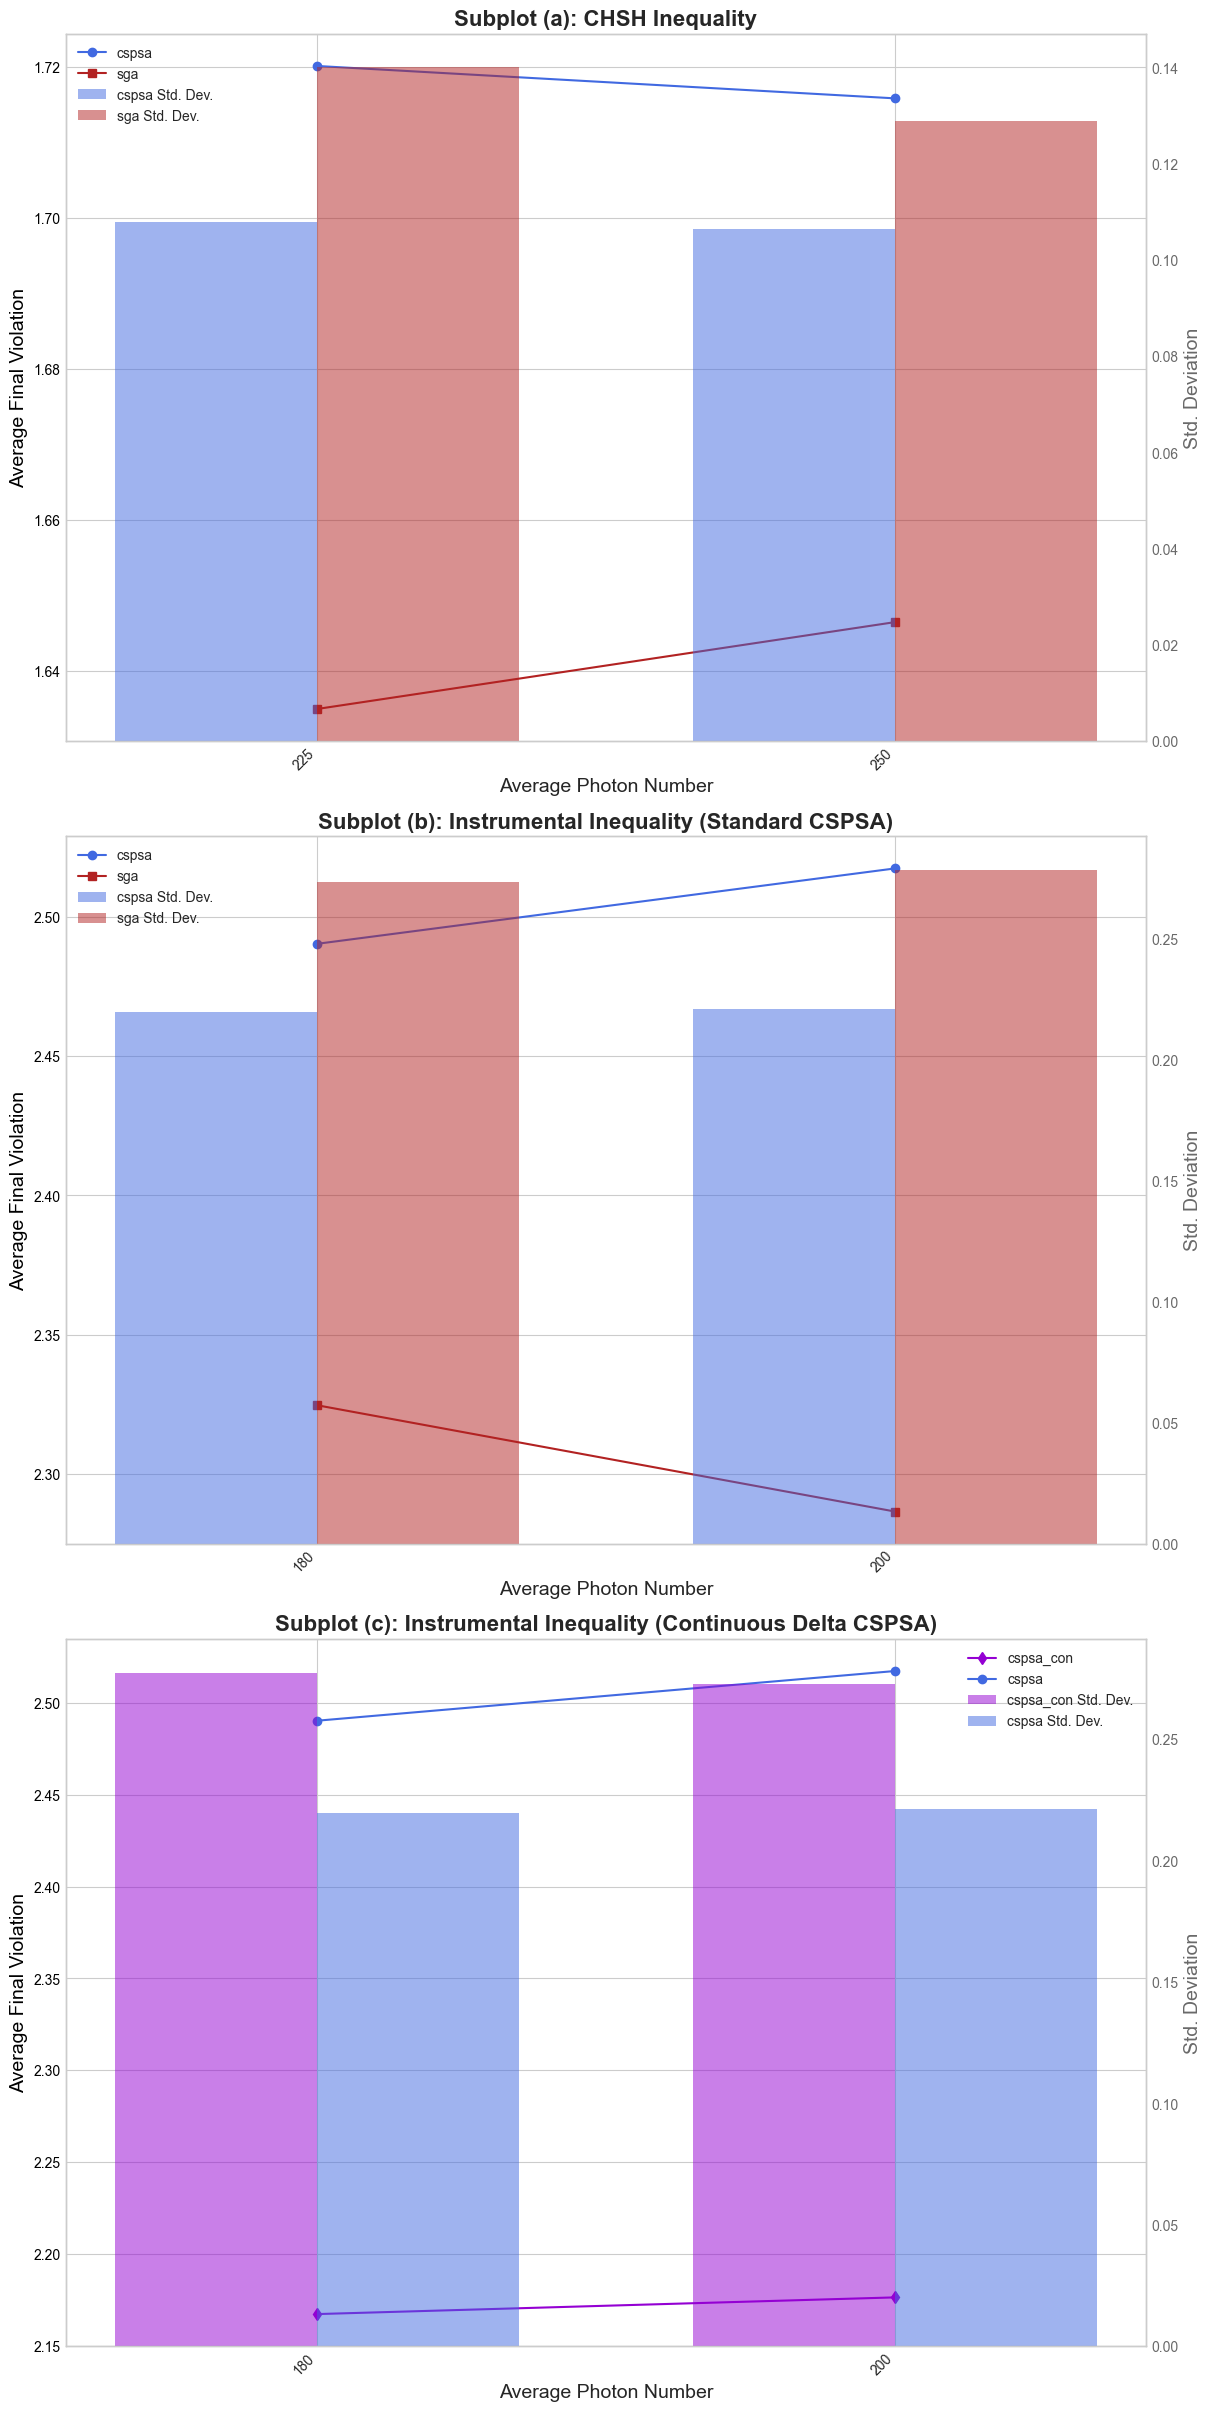

In [423]:
# --- 6. 最终绘图 (修正了颜色和标记) ---

print("\nGenerating Final Figure 3...")
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(3, 1, figsize=(12, 24))
fig.set_constrained_layout(True)

# 绘图辅助函数
def plot_twin_axis_subplot(ax1, results, config, title):
    # --- 准备数据和配置 ---

    # ##############################################################################
    # ## CORRECTED SECTION: Added the missing key for 'CSPSA_Continuous'
    # ##############################################################################
    colors = {'cspsa': 'royalblue', 'sga': 'firebrick', 'cspsa_con': 'darkviolet'}
    line_styles = {'cspsa': 'o-', 'sga': 's-', 'cspsa_con': 'd-'} # <-- FIX IS HERE

    photons = config['photons_list']
    x_positions = np.arange(len(photons))

    # --- 左轴 (ax1): 绘制折线图 ---
    ax1.set_title(title, fontsize=16, weight='bold')
    ax1.set_xlabel('Average Photon Number', fontsize=14)
    ax1.set_ylabel('Average Final Violation', fontsize=14, color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    for algo_name, data in results.items():
        style = line_styles.get(algo_name, '^-') # Default to caret marker if not found
        color = colors.get(algo_name, 'black')    # Default to black if not found
        ax1.plot(x_positions, data['means'], style, color=color, label=algo_name)

    # --- 右轴 (ax2): 创建并绘制条形图 ---
    ax2 = ax1.twinx()
    ax2.set_ylabel('Std. Deviation', fontsize=14, color='dimgray')
    ax2.tick_params(axis='y', labelcolor='dimgray')
    ax2.grid(False)

    bar_width = 0.35
    algo_names = list(results.keys())
    color1 = colors.get(algo_names[0], 'blue')
    color2 = colors.get(algo_names[1], 'red')

    ax2.bar(x_positions - bar_width/2, results[algo_names[0]]['stds'], bar_width, label=f"{algo_names[0]} Std. Dev.", color=color1, alpha=0.5)
    ax2.bar(x_positions + bar_width/2, results[algo_names[1]]['stds'], bar_width, label=f"{algo_names[1]} Std. Dev.", color=color2, alpha=0.5)
    ax2.set_ylim(bottom=0)

    # --- X轴和图例 ---
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels([str(p) for p in photons], rotation=45, ha="right")

    lines, labels = ax1.get_legend_handles_labels()
    bars, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + bars, labels + labels2, loc='best')


# --- 主程序中执行绘图 ---
if __name__ == '__main__':
    # This check ensures the code runs when executed as a script
    plot_twin_axis_subplot(axes[0], results_a, CONFIG_A, CONFIG_A['description'])
    plot_twin_axis_subplot(axes[1], results_b, CONFIG_B, CONFIG_B['description'])
    plot_twin_axis_subplot(axes[2], results_c, CONFIG_C, CONFIG_C['description'])

    plt.savefig("figure3_complete_analysis_final.pdf", format='pdf')
    plt.show()